<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t047_chai1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Clone the Repository and Install Dependencies
!git clone https://github.com/chaidiscovery/chai-lab.git
%cd chai-lab
# Update the torch version in the requirements.in file
file_path = "requirements.in"

try:
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Replace torch version
    updated_lines = [
        line.replace("torch~=2.3.1", "torch~=2.5.1") if "torch~=" in line else line
        for line in lines
    ]

    # Write updated lines back to the file
    with open(file_path, "w") as file:
        file.writelines(updated_lines)

    print(f"Updated 'torch' version in {file_path} to 'torch~=2.5.1' successfully.")

except FileNotFoundError:
    print(f"The file {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Cloning into 'chai-lab'...
remote: Enumerating objects: 1136, done.
remote: Counting objects: 100% (843/843), done.
remote: Compressing objects: 100% (572/572), done.
remote: Total 1136 (delta 590), reused 330 (delta 270), pack-reused 293 (from 1)
Receiving objects: 100% (1136/1136), 19.65 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (678/678), done.
/content/chai-lab
Updated 'torch' version in requirements.in to 'torch~=2.5.1' successfully.


In [18]:
# CHAI-1 설치
%cd chai-lab
!pip install -e .

/content/chai-lab
Obtaining file:///content/chai-lab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for chai_lab (pyproject.toml) ... done
  Created wheel for chai_lab: filename=chai_lab-0.5.1-py3-none-any.whl size=5645 sha256=c5774192b269c3a94055c3f746dedd0f9857f40b2d0a8e0c2b2f0a6cb0293854
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvtssqmm/wheels/8b/08/b0/5179087b10191340994e4693b5dfa069ff0cdf5b4ca3bf3352
Successfully built chai_lab
  Attempting uninstall: chai_lab
    Found existing installation: chai_lab 0.5.1
    Uninstalling chai_lab-0.5.1:
      Successfully uninstalled chai_lab-0.5.1


In [17]:
pip install torch torchvision --upgrade

In [15]:
# Step 2: Download PDB Structure (2ITO)
# Using wget to fetch the PDB file for PDB ID: 2ITO
%cd /content
!wget https://files.rcsb.org/download/2ITO.pdb

/content
--2024-12-14 01:55:03--  https://files.rcsb.org/download/2ITO.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.213.193
Connecting to files.rcsb.org (files.rcsb.org)|132.249.213.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2ITO.pdb.1’

2ITO.pdb.1              [       <=>          ] 244.19K   152KB/s    in 1.6s    

2024-12-14 01:55:05 (152 KB/s) - ‘2ITO.pdb.1’ saved [250047]



In [5]:
from Bio.PDB import PDBParser , NeighborSearch
from Bio.SeqUtils import seq1
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path

# Step 4: Extract Protein Sequence and Ligand SMILES
pdb_file = '2ITO.pdb'
parser = PDBParser(QUIET=True)
structure = parser.get_structure("2ITO", pdb_file)

# Extract the first chain's sequence
chain = next(structure.get_chains())
sequence = "".join([seq1(residue.resname) for residue in chain if residue.id[0] == " "])

In [6]:
# Extract residues with resname 'IRE'
ire_residues = [res for res in structure.get_residues() if res.resname == "IRE"]

if not ire_residues:
    print("No residues with resname 'IRE' found in the PDB file.")
else:
    print(f"Found {len(ire_residues)} residues with resname 'IRE'.")

    # Extract the first 'IRE' residue
    ire_residue = ire_residues[0]
    atoms = list(ire_residue.get_atoms())

    # RDKit molecule construction
    mol = Chem.RWMol()
    atom_mapping = {}

    # Add atoms to the molecule
    for atom in atoms:
        element = atom.element
        # Correct 'CL' to 'Cl' for RDKit compatibility
        if element == "CL":
            element = "Cl"
        try:
            rdkit_atom = Chem.Atom(element)
            idx = mol.AddAtom(rdkit_atom)
            atom_mapping[atom.serial_number] = idx
        except RuntimeError as e:
            print(f"Skipping atom {atom.element} due to error: {e}")

    # Use NeighborSearch to find bonds
    ns = NeighborSearch(list(structure.get_atoms()))
    for atom in atoms:
        start_idx = atom_mapping.get(atom.serial_number)
        if start_idx is None:
            continue
        # Find neighbors within a bond cutoff distance (1.9 Å for covalent bonds)
        neighbors = ns.search(atom.coord, 1.9)
        for neighbor in neighbors:
            # Exclude self-bonds
            if atom.serial_number == neighbor.serial_number:
                continue
            end_idx = atom_mapping.get(neighbor.serial_number)
            if end_idx is not None and not mol.GetBondBetweenAtoms(start_idx, end_idx):
                mol.AddBond(start_idx, end_idx, Chem.BondType.SINGLE)

    # Generate SMILES
    try:
        smiles = Chem.MolToSmiles(mol)
        print("IRE residue SMILES:", smiles)
    except Exception as e:
        print(f"Failed to generate SMILES: {e}")

Found 1 residues with resname 'IRE'.
IRE residue SMILES: COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1


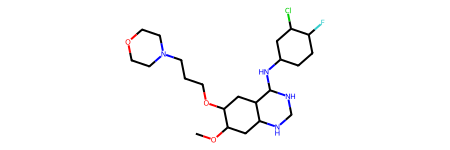

In [8]:
m1=Chem.MolFromSmiles(smiles)
m1

In [9]:
fasta_file = Path("2ITO_combined.fasta")
with open(fasta_file, "w") as f:
    f.write(f">protein|name=example-of-long-protein\n{sequence}\n")
    f.write(f">ligand|name=example-ligand-as-smiles\n{smiles}\n")
print(f"Combined FASTA file saved to {fasta_file}")

Combined FASTA file saved to 2ITO_combined.fasta


In [10]:
!cat 2ITO_combined.fasta

>protein|name=example-of-long-protein
GEAPNQALLRILKETEFKKIKVLSSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLMDEEDMDDVVDADEYLIP
>ligand|name=example-ligand-as-smiles
COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1


In [20]:
# Step 6: Run CHAI-1 with Combined FASTA
import chai_lab.chai1 as chai1

# Step 6: Run CHAI-1 with Combined FASTA
from chai_lab.chai1 import run_inference
%cd /content
# Define CHAI-1 parameters
output_dir = Path("output")
candidates = run_inference(
    fasta_file=fasta_file,
    output_dir=output_dir,
    num_trunk_recycles=3,  # Trunk recycling steps
    num_diffn_timesteps=200,  # Diffusion steps
    seed=42,
    device="cuda:0",  # Use GPU
    use_esm_embeddings=True
)

print(f"CHAI-1 output saved to {output_dir}")

/content
downloading https://chaiassets.com/chai1-inference-depencencies/conformers_v1.apkl


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/feature_embedding.pt
downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/bond_loss_input_proj.pt
downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/token_embedder.pt
downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/trunk.pt
downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/diffusion_module.pt
downloading https://chaiassets.com/chai1-inference-depencencies/models_v2/confidence_head.pt


Diffusion steps: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]


Score=0.8539, writing output to output/pred.model_idx_0.cif
Score=0.8546, writing output to output/pred.model_idx_1.cif
Score=0.8525, writing output to output/pred.model_idx_2.cif
Score=0.8601, writing output to output/pred.model_idx_3.cif
Score=0.8579, writing output to output/pred.model_idx_4.cif
CHAI-1 output saved to output


In [21]:
!pip install nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 97.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00
  Created wheel for nglview:

In [22]:
import os
from pathlib import Path
from Bio.PDB import MMCIFParser, PDBParser, PDBIO, Superimposer, Select
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview as nv

In [23]:
# Define paths
output_dir = Path("output")
original_pdb = "2ITO.pdb"
predicted_files = sorted(output_dir.glob("*.cif"))

# Initialize MMCIFParser
cif_parser = MMCIFParser(QUIET=True)

# Class for extracting ligands
class DynamicLigandSelect(Select):
    def __init__(self, target_resname):
        self.target_resname = target_resname

    def accept_residue(self, residue):
        return residue.resname == self.target_resname

# Fix element assignment in the structure
def fix_elements(structure):
    for atom in structure.get_atoms():
        if atom.element.strip() == "":
            # Use the first letter of the atom name as a fallback for element
            atom.element = atom.get_name()[0]
    return structure

# Detect ligands in a structure
def detect_ligand_resnames(structure):
    ligand_resnames = set()
    for residue in structure.get_residues():
        if residue.id[0] != " ":  # Hetero atoms (e.g., ligands)
            ligand_resnames.add(residue.resname)
    return ligand_resnames

# RMSD and visualization
rmsd_values = []

for idx, pred_file in enumerate(predicted_files):
    pred_structure = cif_parser.get_structure(f"predicted_{idx}", pred_file)
    pred_structure = fix_elements(pred_structure)  # Fix element assignments
    ligand_resnames = detect_ligand_resnames(pred_structure)

    if not ligand_resnames:
        print(f"No ligands found in {pred_file.name}. Skipping.")
        continue

    for resname in ligand_resnames:
        predicted_ligand_pdb = f"predicted_ligand_{idx}_{resname}.pdb"

        # Save ligand from predicted structure
        io = PDBIO()
        io.set_structure(pred_structure)
        io.save(predicted_ligand_pdb, DynamicLigandSelect(resname))

        # Load predicted ligand
        predicted_ligand = Chem.MolFromPDBFile(predicted_ligand_pdb, removeHs=False)
        if not predicted_ligand:
            print(f"Failed to load predicted ligand for {pred_file.name}, resname: {resname}.")
            continue

        # Load original ligand
        original_ligand = Chem.MolFromPDBFile("original_ligand.pdb", removeHs=False)
        if not original_ligand:
            raise ValueError("Failed to load original ligand.")

        # Calculate RMSD
        AllChem.EmbedMolecule(original_ligand)
        AllChem.EmbedMolecule(predicted_ligand)
        rmsd = AllChem.GetBestRMS(original_ligand, predicted_ligand)
        rmsd_values.append((pred_file.name, resname, rmsd))
        print(f"File: {pred_file.name}, Resname: {resname}, RMSD: {rmsd:.3f} Å")

        # Visualization
        view = nv.NGLWidget()
        view.add_component(original_pdb, default_representation=True)
        view.add_representation('cartoon', selection='protein', color='blue', component=0)
        view.add_representation('licorice', selection='ligand', color='red', component=0)

        view.add_component(str(pred_file), default_representation=True)
        view.add_representation('cartoon', selection='protein', color='green', component=1)
        view.add_representation('licorice', selection='ligand', color='yellow', component=1)

        print(f"Visualization for {pred_file.name}, Resname: {resname} is ready.")
        view.display()

# Summarize RMSD values
print("\nSummary of RMSD values:")
for file_name, resname, rmsd in rmsd_values:
    print(f"{file_name} ({resname}): RMSD = {rmsd:.3f} Å")
    print(f"{file_name} ({resname}): RMSD = {rmsd:.3f} Å")

[02:07:36] Cannot determine element for PDB atom #1
[02:07:36] Cannot determine element for PDB atom #1
[02:07:36] Cannot determine element for PDB atom #1


Failed to load predicted ligand for pred.model_idx_0.cif, resname: LIG2.
Failed to load predicted ligand for pred.model_idx_1.cif, resname: LIG2.
Failed to load predicted ligand for pred.model_idx_2.cif, resname: LIG2.
Failed to load predicted ligand for pred.model_idx_3.cif, resname: LIG2.
Failed to load predicted ligand for pred.model_idx_4.cif, resname: LIG2.

Summary of RMSD values:


[02:07:36] Cannot determine element for PDB atom #1
[02:07:36] Cannot determine element for PDB atom #1
